In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
import lseg.data as ld
ld.open_session()


<lseg.data.session.Definition object at 0x1ebe836f6d0 {name='workspace'}>

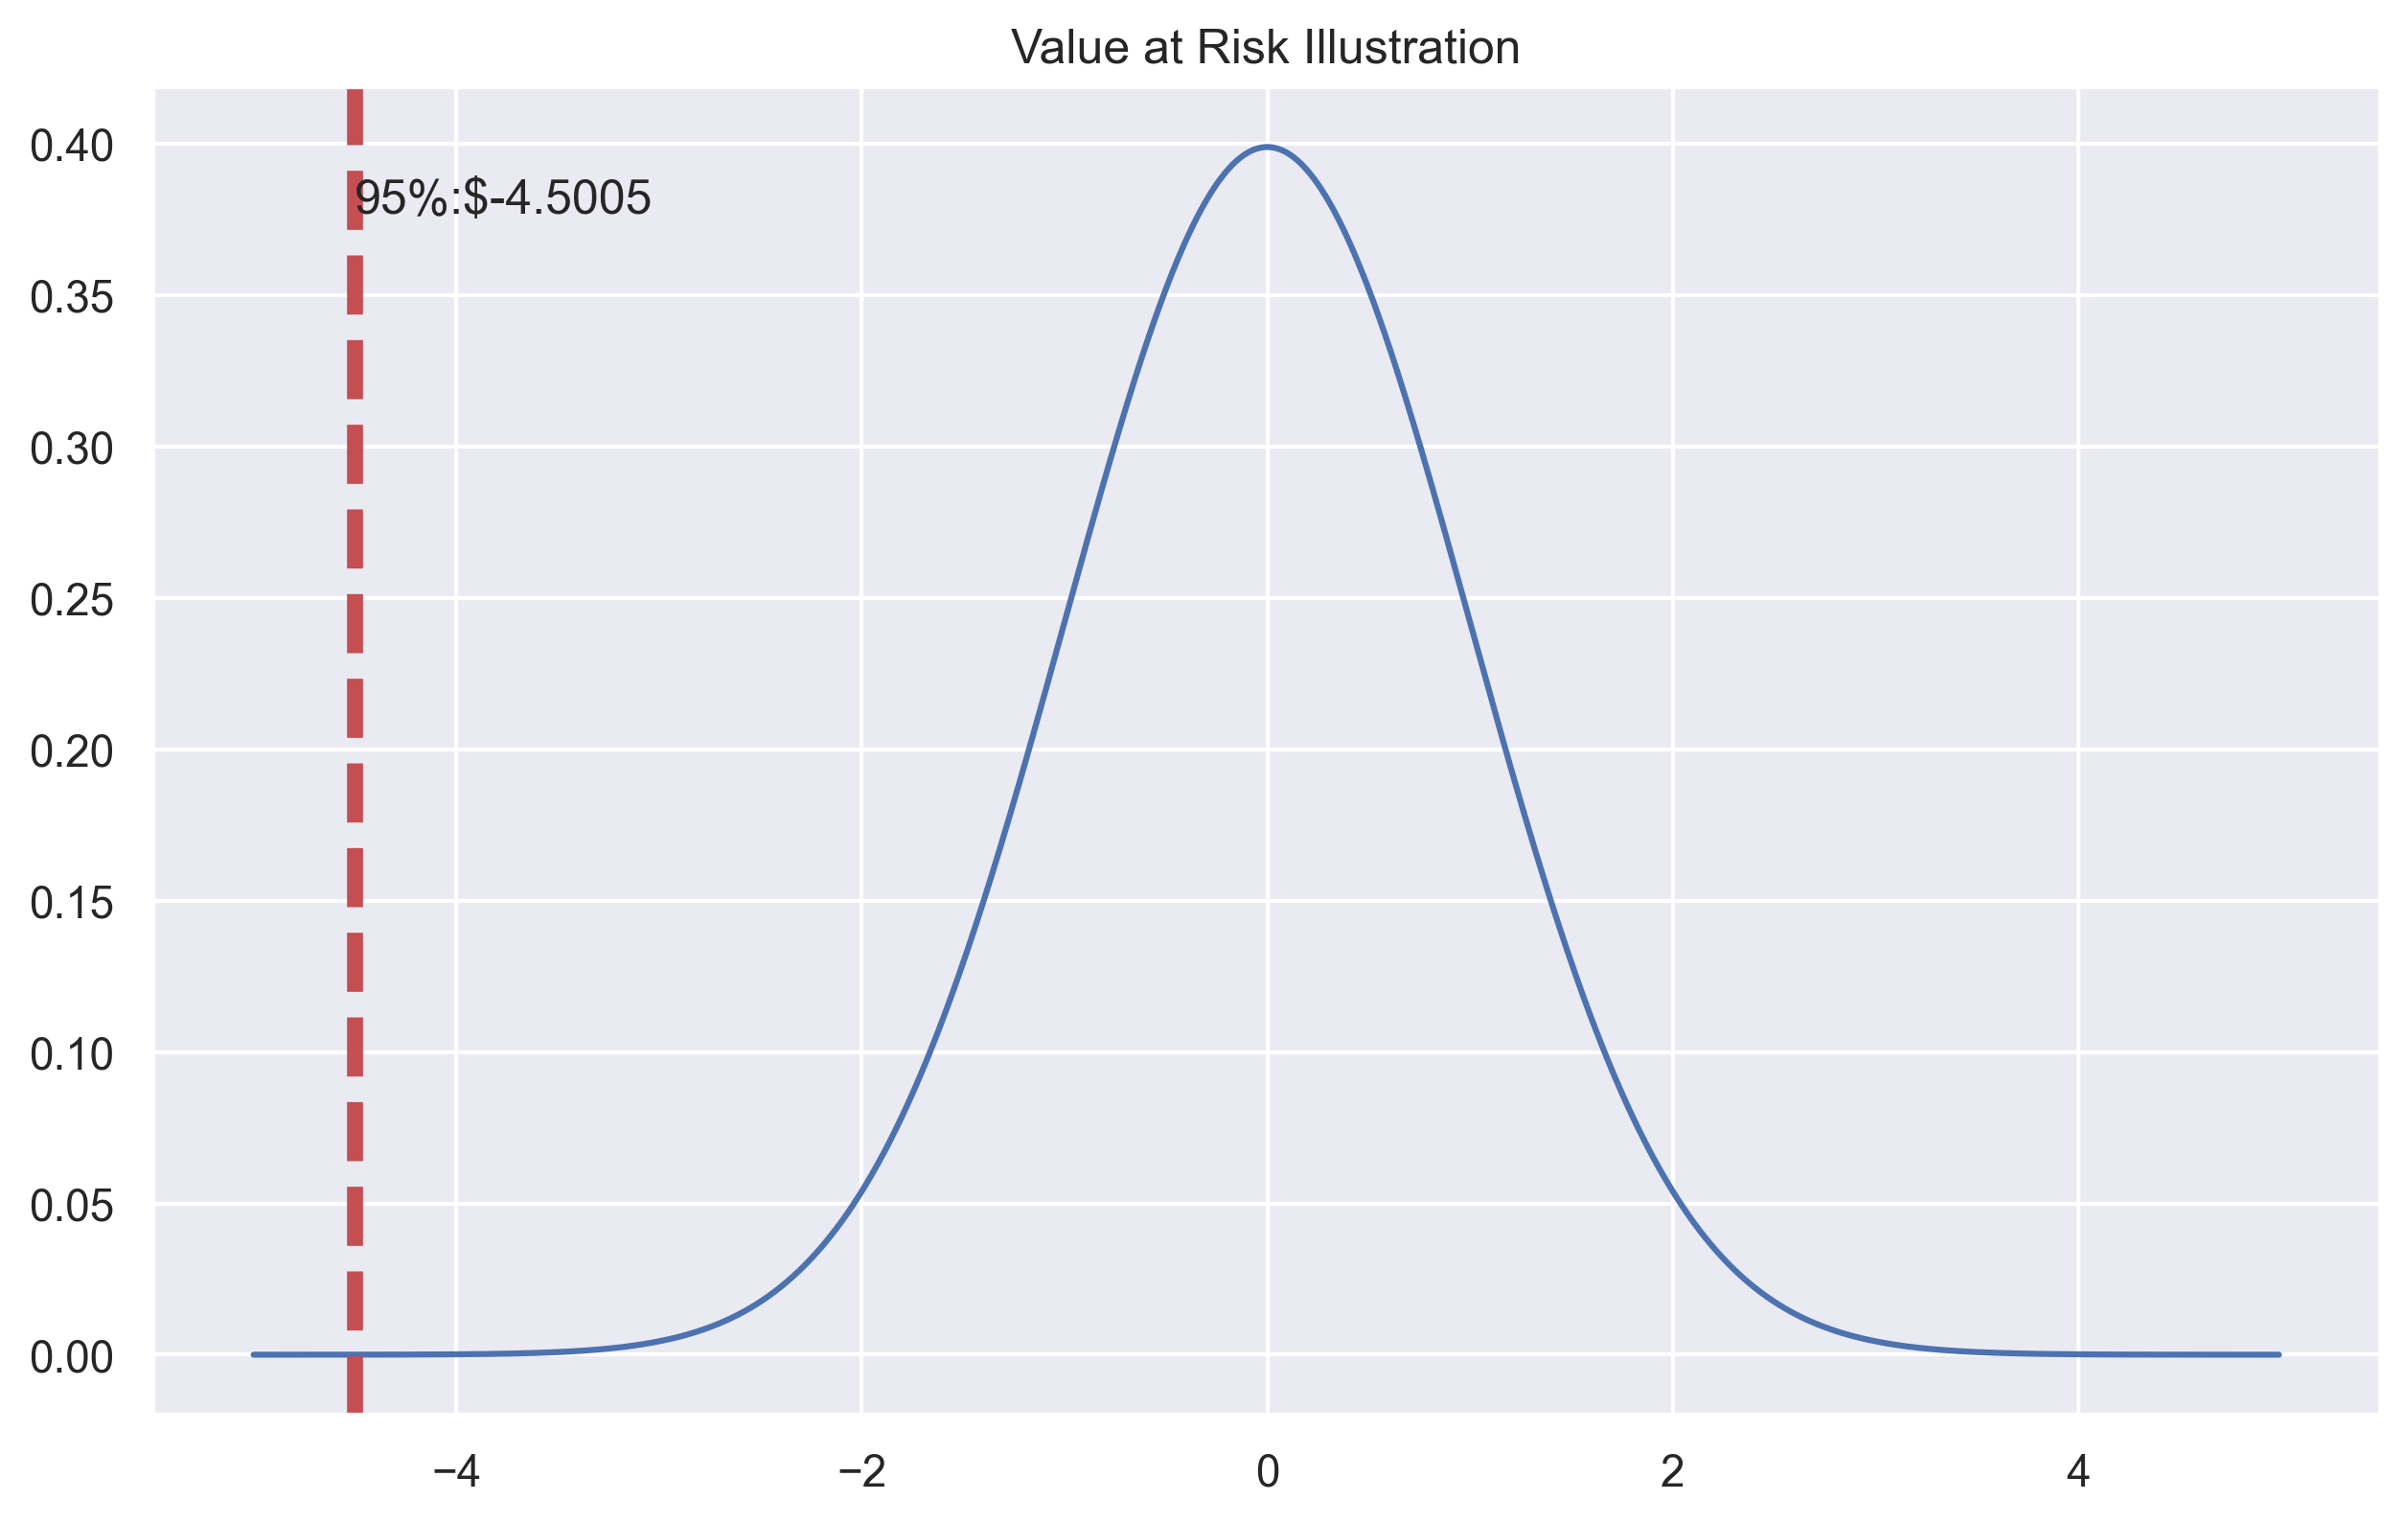

In [3]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [4]:
RICS = ["TSLA.N", "MSFT.O", "NVDA.O"]
ts = ld.get_data(RICS,
                   [
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-10-01,Frq=D).date',
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-01-01,Frq=D)'
                   ])
ts2 = ts.drop_duplicates()
ts2

,Instrument,Date,Price Close
0,TSLA.N,2021-01-04,243.29309
1,TSLA.N,2021-01-05,245.036422
2,TSLA.N,2021-01-06,252.063081
3,TSLA.N,2021-01-07,272.039728
4,TSLA.N,2021-01-08,293.379707
...,...,...,...
3570,NVDA.O,2025-09-24,<NA>
3571,NVDA.O,2025-09-25,<NA>
3572,NVDA.O,2025-09-26,<NA>
3573,NVDA.O,2025-09-29,<NA>


In [5]:
stocks = ts2.pivot(index="Date", columns="Instrument", values="Price Close")
stocks

Instrument,MSFT.O,NVDA.O,TSLA.N
Date,,,
2021-01-04,217.69,13.1135,243.29309
2021-01-05,217.9,13.40475,245.036422
2021-01-06,212.25,12.6145,252.063081
2021-01-07,218.29,13.344,272.039728
2021-01-08,219.62,13.27675,293.379707
...,...,...,...
2025-09-25,<NA>,<NA>,<NA>
2025-09-26,<NA>,<NA>,<NA>
2025-09-29,<NA>,<NA>,<NA>


In [6]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

Instrument,MSFT.O,NVDA.O,TSLA.N
Date,,,
2021-01-05,0.000964,0.021967,0.00714
2021-01-06,-0.026271,-0.060762,0.028273
2021-01-07,0.02806,0.05622,0.076269
2021-01-08,0.006074,-0.005052,0.07552
2021-01-11,-0.009746,0.025635,-0.082121
...,...,...,...
2024-12-24,0.00933,0.00393,0.070098
2024-12-26,-0.002781,-0.00207,-0.017983
2024-12-27,-0.017453,-0.021088,-0.050655


In [7]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
#weights =  np.array([.333, .333, .333], dtype='float')
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [8]:
weights

array([0.42977708, 0.39027006, 0.17995286])

In [9]:
stocks_returns_mean

Instrument
MSFT.O    0.000658
NVDA.O    0.002317
TSLA.N    0.000504
dtype: Float64

In [10]:
print(stocks_returns_mean)
print(weights)
print(cov_var)
print(port_std) 

Instrument
MSFT.O    0.000658
NVDA.O    0.002317
TSLA.N    0.000504
dtype: Float64
[0.42977708 0.39027006 0.17995286]
Instrument    MSFT.O    NVDA.O    TSLA.N
Instrument                              
MSFT.O      0.000270  0.000343  0.000258
NVDA.O      0.000343  0.001087  0.000574
TSLA.N      0.000258  0.000574  0.001430
0.02229968234087876


In [11]:
weights = np.array([.2,.3,.4])

In [12]:
stocks_returns_mean = stocks_returns.mean()
stocks_returns_mean

Instrument
MSFT.O    0.000658
NVDA.O    0.002317
TSLA.N    0.000504
dtype: Float64

In [13]:
initial_investment = 1000000
conf_level = 0.95

In [14]:
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [15]:
port_std

np.float64(0.02361421880986053)

In [16]:
alpha = norm.ppf(.05, stocks_returns_mean, port_std)

In [17]:
alpha

array([-0.03818382, -0.03652484, -0.03833769])

In [18]:
stocks.columns

Index(['MSFT.O', 'NVDA.O', 'TSLA.N'], dtype='string', name='Instrument')

## Variance-Covariance Method

In [19]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
    VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
    print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for MSFT.O is 38183.81817313132 
Parametric VaR result for NVDA.O is 36524.84241452394 
Parametric VaR result for TSLA.N is 38337.69387216761 


In [20]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [21]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for MSFT.O is 38183.81817313132 
Parametric VaR result for NVDA.O is 36524.84241452394 
Parametric VaR result for TSLA.N is 38337.69387216761 
--------------------------------------------------


array([38183.81817313, 36524.84241452, 38337.69387217])

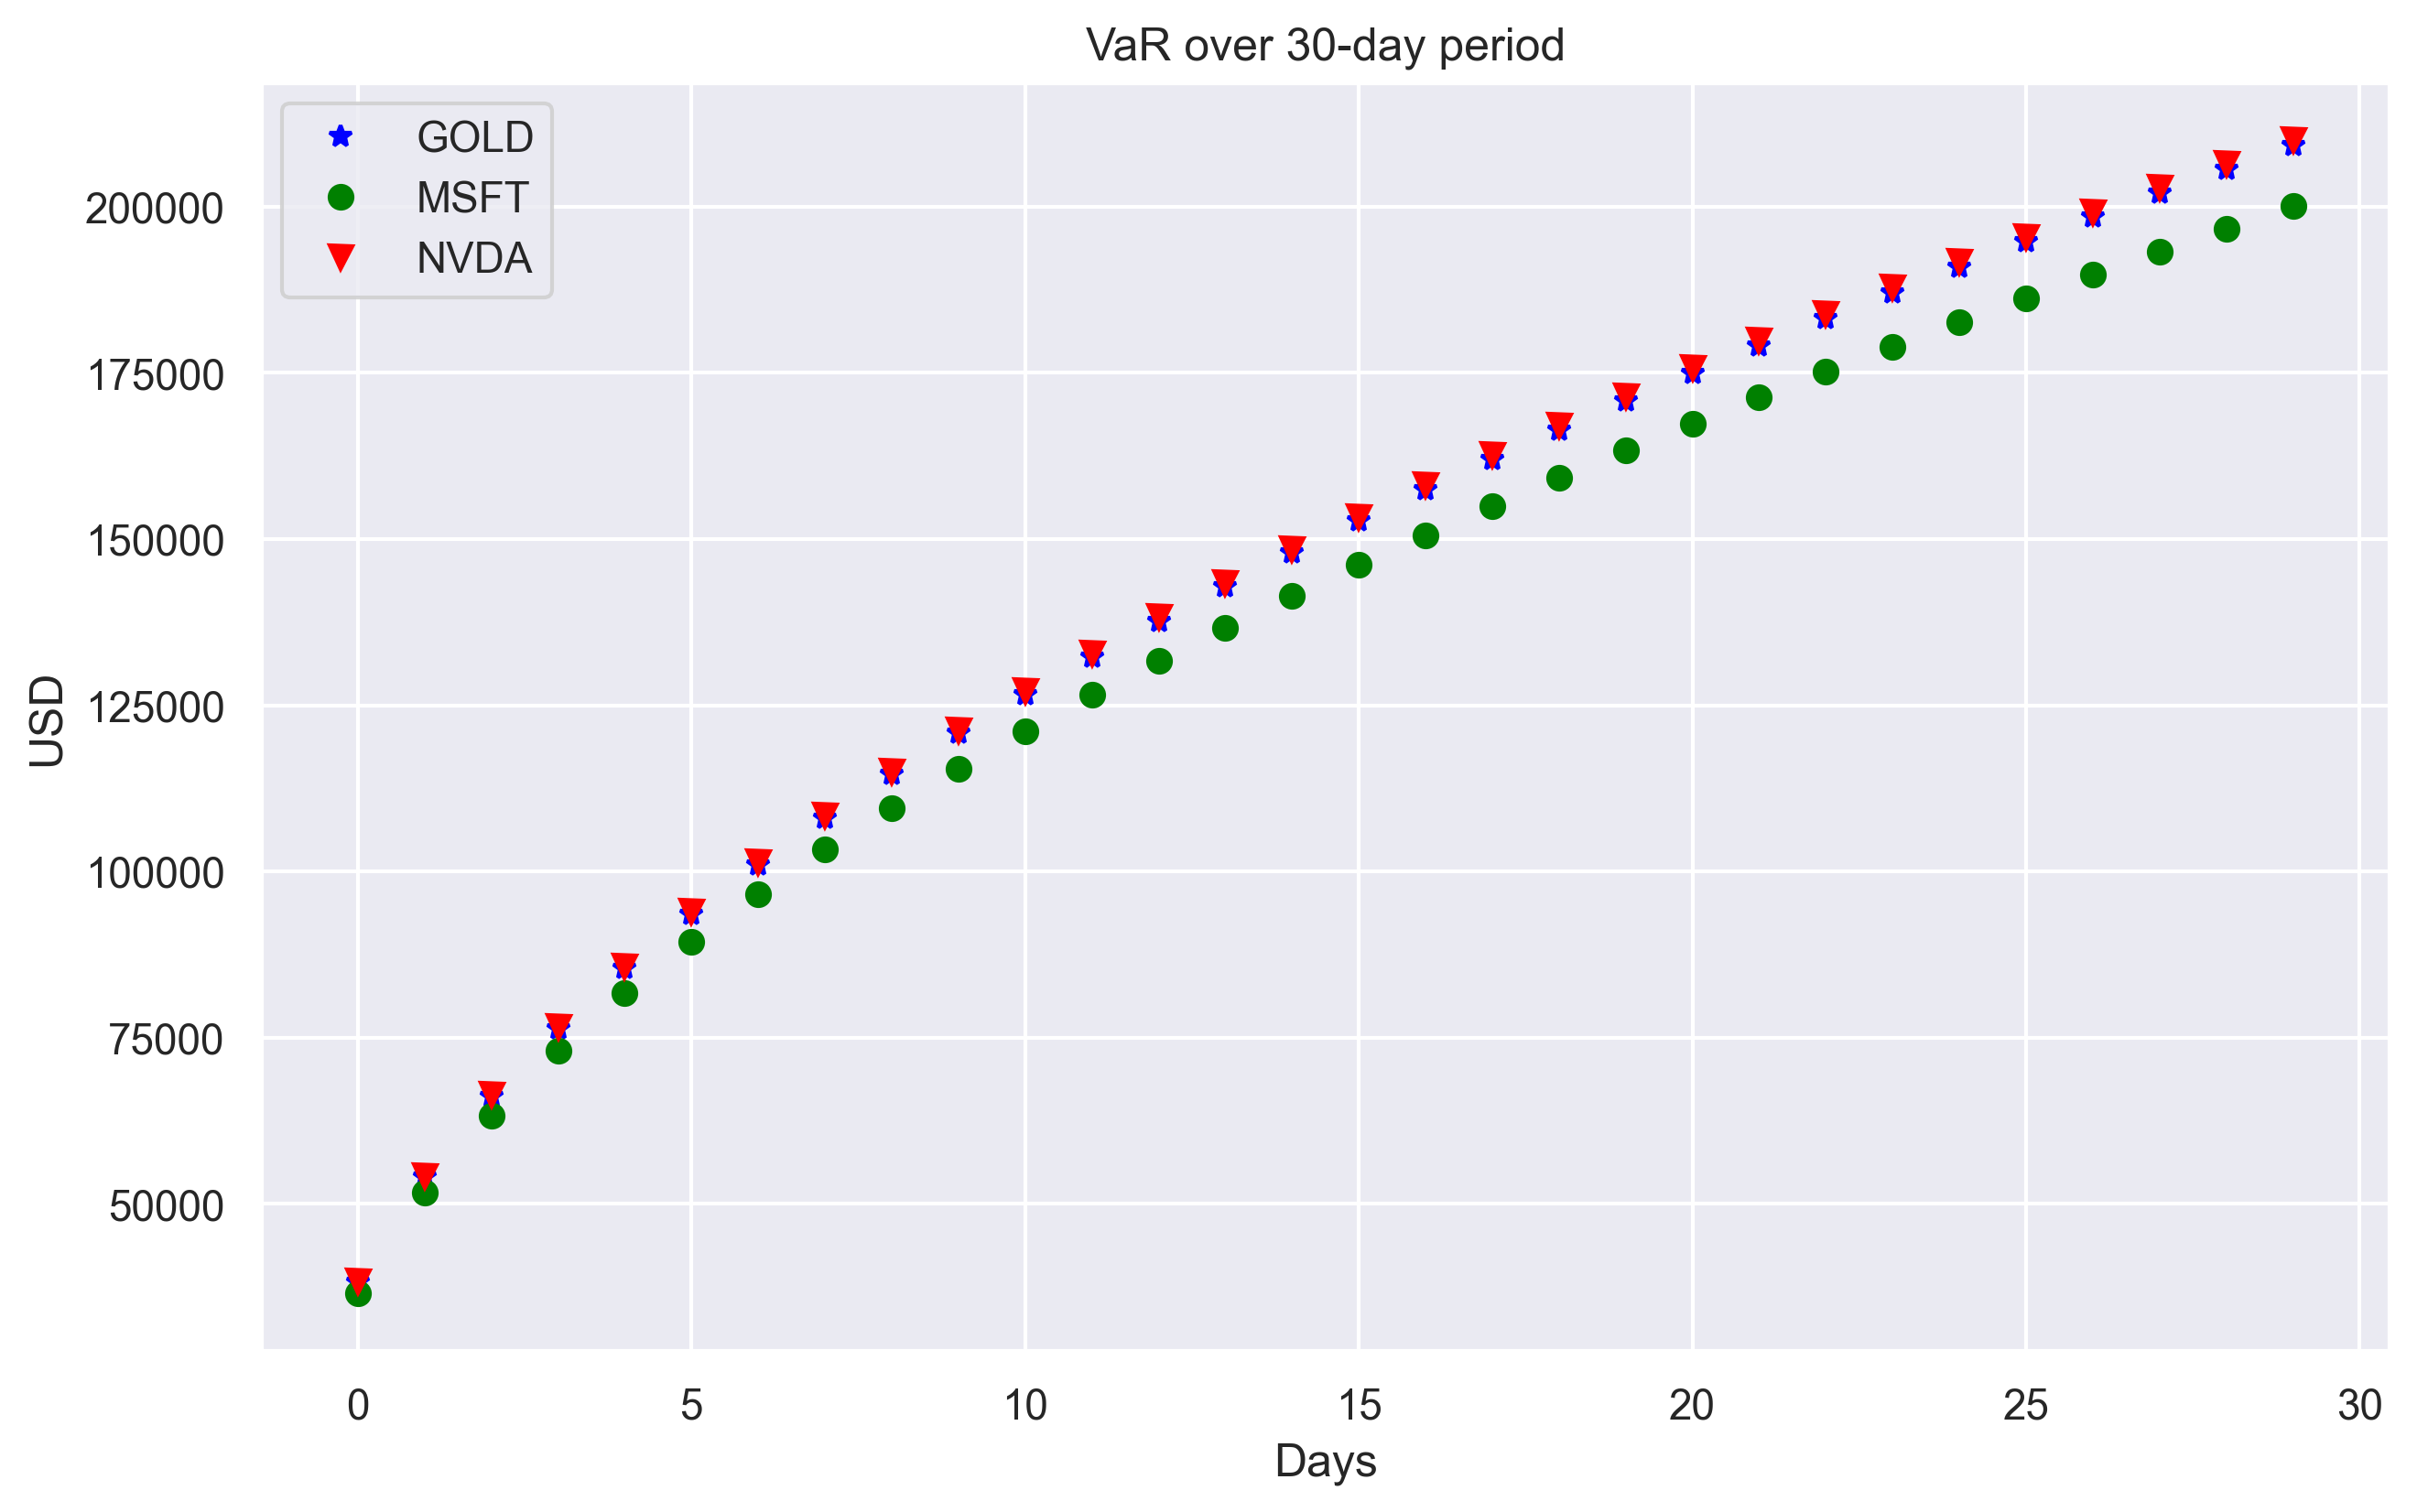

In [22]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='GOLD')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='NVDA')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical


In [23]:
for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
    print(np.percentile(stocks_returns.loc[:, i], 5))

-0.02712200572752379
-0.049828831937088286
-0.06286050217304967


In [24]:
stocks_returns.loc[:, 'NVDA.O']

Date
2021-01-05    0.021967
2021-01-06   -0.060762
2021-01-07     0.05622
2021-01-08   -0.005052
2021-01-11    0.025635
                ...   
2024-12-24     0.00393
2024-12-26    -0.00207
2024-12-27   -0.021088
2024-12-30    0.003497
2024-12-31    -0.02355
Name: NVDA.O, Length: 1004, dtype: Float64

In [25]:
np.percentile(stocks_returns.loc[:, 'NVDA.O'], 5)

np.float64(-0.049828831937088286)

In [26]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [27]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of MSFT.O's return is -0.0271
Historical VaR result for MSFT.O is 27122.01 
----------------------------------------------------------------------
Based on historical values 95% of NVDA.O's return is -0.0498
Historical VaR result for NVDA.O is 49828.83 
----------------------------------------------------------------------
Based on historical values 95% of TSLA.N's return is -0.0629
Historical VaR result for TSLA.N is 62860.50 
----------------------------------------------------------------------


## Monte Carlo VaR

In [28]:
x = np.random.uniform(-1, 1, 100) 
y = np.random.uniform(-1, 1, 100)

In [29]:
y

array([ 0.79276915,  0.22685237, -0.76125057, -0.96627527, -0.77763834,
        0.76134003, -0.63480891, -0.29543989, -0.2607186 , -0.56107468,
        0.31231738,  0.59980605,  0.7286416 ,  0.5075082 , -0.59967223,
       -0.68133953, -0.25240508, -0.35912821, -0.90083732, -0.26328726,
       -0.56238437, -0.07968558,  0.58398961,  0.41684457, -0.98319442,
       -0.84735108,  0.97567172,  0.69667341, -0.58875538, -0.94226719,
       -0.98816117,  0.54286706, -0.08610152,  0.53830651,  0.27636653,
        0.77846552,  0.2641816 , -0.22863154, -0.35766378,  0.20768685,
       -0.80045548,  0.79675404,  0.56204914,  0.53790799,  0.26435784,
       -0.13620047, -0.96001392,  0.91079359,  0.31874492, -0.68589428,
       -0.94123519,  0.37189242, -0.37508185, -0.05863773, -0.99833145,
        0.2223726 , -0.64396888,  0.26720433, -0.0968072 , -0.74803842,
        0.60225076,  0.80093125,  0.22021588,  0.84650995, -0.6038172 ,
        0.1960675 ,  0.48771073,  0.26279769, -0.7970312 ,  0.18

In [30]:
x

array([ 0.3036489 , -0.06423723,  0.91610463,  0.92161768,  0.71394701,
       -0.85280557, -0.79408718,  0.8361805 , -0.11943172, -0.26148062,
        0.71068074,  0.00655513, -0.22985368,  0.71234382, -0.84551589,
        0.00970189,  0.5143216 ,  0.46750044,  0.1831731 , -0.76841802,
        0.05352975,  0.94376669,  0.19055401,  0.09283514, -0.92059184,
        0.80990345, -0.78050206,  0.78090644, -0.96065707, -0.62666573,
       -0.72447235,  0.00171966, -0.43210086, -0.22122424, -0.32402068,
        0.73359215,  0.71306554,  0.15430658, -0.70149807, -0.30882547,
        0.03436733,  0.04059785, -0.99971582,  0.30253153, -0.5484087 ,
        0.81873411,  0.5094489 , -0.7798175 ,  0.331216  ,  0.4641672 ,
       -0.76077775, -0.99823271,  0.19584392, -0.05298686, -0.97977012,
       -0.78641061,  0.67153184,  0.6110561 , -0.88486219, -0.56519907,
        0.67739795, -0.81901754,  0.81714831,  0.33327102, -0.3022745 ,
       -0.89315313,  0.33041868, -0.64404462, -0.04245554,  0.99

In [31]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [32]:
pi_calc(x,y)

pi value is 2.96


In [33]:
len(stocks.columns)

3

In [34]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    print(i)

0
1
2


In [35]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [36]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,0.400176,0.848505,1.341783
1,-0.824595,0.487857,-0.741758
2,1.157297,1.148332,-0.897924
3,-0.953921,-0.712539,0.333239
4,0.104894,1.732552,-0.489408
...,...,...,...
995,0.754161,-0.320931,-0.728797
996,-0.069563,-0.222798,-2.154576
997,0.239957,1.653925,0.900476
998,-0.602374,-0.122265,1.830119


In [37]:
MC_percentile95 = []
for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
    print(i,j)

Simulation 1 0
Simulation 2 1
Simulation 3 2


In [38]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [39]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.5125
Simulation VaR result for Simulation 1 is 1512454.01 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.4482
Simulation VaR result for Simulation 2 is 1448160.41 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.5877
Simulation VaR result for Simulation 3 is 1587662.79 
----------------------------------------------------------------------
